In [239]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Чтение и знакомство с данными

In [240]:
df_trans = pd.read_excel(r"data\transactions_data.xlsx")
df_trans.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena


In [241]:
df_clients = pd.read_json(r"data\clients_data.json")
df_clients.head()

,id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,None,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


## Разберемся с данными из df_trans

#### Обработка пропущенных значений

In [242]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    9526 non-null   object 
 1   client_id         9798 non-null   object 
 2   transaction_date  10000 non-null  object 
 3   service           10000 non-null  object 
 4   amount            9540 non-null   float64
 5   payment_method    10000 non-null  object 
 6   city              10000 non-null  object 
 7   consultant        10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


In [243]:
df_trans.isnull().sum()

transaction_id      474
client_id           202
transaction_date      0
service               0
amount              460
payment_method        0
city                  0
consultant            0
dtype: int64

transaction_id и client_id уникальные значения, которые должны выдаваться при создании транзакции и регистрации клиента соответственно, поэтому удалим строки с пропущенными значениями из DataFrame, а удаленные строки запишем в отдельные файлы, чтобы в последующем мы могли передать их на анализ отделам, занимающимися данными вопросами.

In [244]:
df_trans_transId_null = df_trans[df_trans['transaction_id'].isna()]
df_trans_transId_null.to_excel("data\\problem_data\\transaction_id_Null.xlsx", index = False)

In [245]:
df_trans_clientId_null = df_trans[df_trans['client_id'].isna()]
df_trans_clientId_null.to_excel("data\\problem_data\\client_id_Null.xlsx", index = False)

In [246]:
df_trans = df_trans.dropna(subset=["transaction_id", "client_id"])
df_trans.isnull().sum()

transaction_id        0
client_id             0
transaction_date      0
service               0
amount              426
payment_method        0
city                  0
consultant            0
dtype: int64

также присваивать в amount нельзя какие-то случайные значения, или 0 нельзя, поэтому удалим данные строки

In [247]:
df_trans_amount_null = df_trans[df_trans['amount'].isna()]
df_trans_amount_null.to_excel("data\\problem_data\\amount_Null.xlsx", index = False)

In [248]:
df_trans = df_trans.dropna(subset=['amount'])
print(f"Строк с NaN значениями в df_trans: {df_trans.isnull().sum().sum()}")

Строк с NaN значениями в df_trans: 0


#### Проверка данных на корректность и их обработка

Начнем проверку на корректность данных, для начала сумму транзакции (должна быть больше 0).

In [249]:
df_trans[df_trans["amount"] <= 0]

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant


***Данные сумм транзакций корректны***

Переведем даты в тип datetime и проверим их на корректность

In [250]:
df_trans['transaction_date'] = pd.to_datetime(df_trans['transaction_date'], errors='coerce')
df_data_error = df_trans[df_trans['transaction_date'] >= datetime.now()]
df_trans = df_trans[df_trans['transaction_date'] < datetime.now()]

df_data_error.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant


***Все данные с датами транзакций корректны***

Проверим способы оплаты и тип оказанной финансовой услуги на корректность с логической точки зрения

In [251]:
df_trans["payment_method"].unique()

array(['Банковский перевод', 'Неизвестно', 'Кредитная карта',
       'Криптовалюта', 'Наличные'], dtype=object)

In [252]:
df_trans["service"].unique()

array(['Структурирование капитала', 'Инвестиционное консультирование',
       'Неизвестная услуга', 'Налоговое планирование',
       'Управление активами', 'Финансовое планирование'], dtype=object)

***Данные корректны***

## Разберемся с df_clients

#### Обработка пропущенных значений

In [253]:
df_clients.isnull().sum()

id              1
age           983
gender       3319
net_worth     475
dtype: int64

Наиболее важно поле id для индификации клиента, удалим поле с пропущенным значением (либо можно было бы заполнить уникальным значением и хешировать)

In [254]:
df_clients = df_clients.dropna(subset=["id"])

Остальные значения по-моему мнению могут быть Nan так как они не так важны

#### Проверка данных на корректность и их обработка

##### Прверим возраст на корректность

In [255]:
df_clients[df_clients["age"] <= 0]

,id,age,gender,net_worth


In [256]:
df_clients[df_clients["age"] >= 100]

,id,age,gender,net_worth


***Возраст корректен***

##### Проверим пол на корректность

In [257]:
df_clients["gender"].unique()

array(['Мужчина', 'Женщина', None], dtype=object)

***Пол корректен***

##### Чистая стоимость активов клиента

In [258]:
df_clients[df_clients["net_worth"] < 0]

,id,age,gender,net_worth


***корректно***

## Решение задач

#### 2. Анализ данных

##### Определить топ-5 наиболее популярных услуг по количеству заказов.

In [259]:
top_services = df_trans['service'].value_counts().head(5)
service_names = top_services.index.tolist()
service_counts = top_services.values.tolist()
top5_famous_service = dict()
print("Топ 5 самых популярных услуг", '\n')
for key, val in zip(service_names, service_counts):
    top5_famous_service[key] = val
    print(f"Услуга: {key}, Количество заказов: {val}")

Топ 5 самых популярных услуг 

Услуга: Инвестиционное консультирование, Количество заказов: 1956
Услуга: Управление активами, Количество заказов: 1606
Услуга: Финансовое планирование, Количество заказов: 1242
Услуга: Налоговое планирование, Количество заказов: 1218
Услуга: Структурирование капитала, Количество заказов: 1196


##### Рассчитать среднюю сумму транзакций по каждому городу.

In [260]:
df_trans.groupby(by="city")["amount"].sum().sort_values(ascending = False).head(5).to_dict()

{'Неизвестный город': 15454021.164274579,
 'Port Michellemouth': 9714997.880923014,
 'New Tommyborough': 9054069.503499499,
 'Kaneburgh': 9050556.916716697,
 'Johnsonfort': 8835446.259065658}

Так как неизвестный город наверное не предполагался, то нужный нам ***Port Michellemouth*** с суммой транзакций около ***9714997.8***

##### Вычислить процент транзакций по способам оплаты (наличные, банковский перевод и т. д.). 

In [261]:
payment_counts = df_trans['payment_method'].value_counts(normalize=True) * 100
payment_counts = payment_counts.round(2)
print(payment_counts)

payment_method
Кредитная карта       40.04
Банковский перевод    34.59
Неизвестно            10.15
Наличные               9.96
Криптовалюта           5.27
Name: proportion, dtype: float64


##### Рассчитать выручку за последний месяц (по сумме amount)

In [262]:
sum_trans_last_month = df_trans[df_trans["transaction_date"] >= datetime.now() - timedelta(days=60)]["amount"].sum().round()
print(f"Вырочка за последний месяц составила: {sum_trans_last_month}")

Вырочка за последний месяц составила: 130778122.0


#### 3. Объединение данных

##### Объединить транзакции с клиентскими данными (по id). 

In [263]:
df_merged = pd.merge(df_trans, df_clients, left_on='client_id', right_on = 'id', how='left')
df_merged.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,id,age,gender,net_worth
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,59.0,Женщина,3992281.84


##### Создать новую колонку с уровнями активов. 

In [264]:
def asset_level_f(val):
    if val < 10**5:
        return "Низкий капитал"
    elif val < 10 ** 6:
        return "Средний капитал"
    else:
        return "Высокий капитал"

df_merged["asset_level"] = df_merged["net_worth"].apply(asset_level_f)
df_merged.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,id,age,gender,net_worth,asset_level
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46,Высокий капитал
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29,Средний капитал
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28,Высокий капитал
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92,Высокий капитал
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,59.0,Женщина,3992281.84,Высокий капитал


##### Провести анализ по уровням активов и определить, какие категории клиентов приносят наибольшую выручку. 

In [265]:
dict_amount_assetL_float = df_merged.groupby("asset_level")["amount"].sum().sort_values().to_dict()
dict_amount_assetL_int = {key: round(val) for key, val in dict_amount_assetL_float.items()}
sum_amount = sum(dict_amount_assetL_int.values())
dict_amount_assetL_normalize = {key: f"{round(val / sum_amount * 100, 1)}%" for key, val in dict_amount_assetL_int.items()}
print(dict_amount_assetL_int)
print(dict_amount_assetL_normalize)

{'Низкий капитал': 6813887, 'Средний капитал': 65392167, 'Высокий капитал': 326350355}
{'Низкий капитал': '1.7%', 'Средний капитал': '16.4%', 'Высокий капитал': '81.9%'}


Как мы видим, наибольшую выручку приносят клиенты с высоким капиталом (почти 82%), примерно в 5 раз меньше клиенты со средним капиталом (16.4%) и всего 1.7% клиенты с низким капиталом

#### 4. Визуализация

##### Построить распределение сумм транзакций.

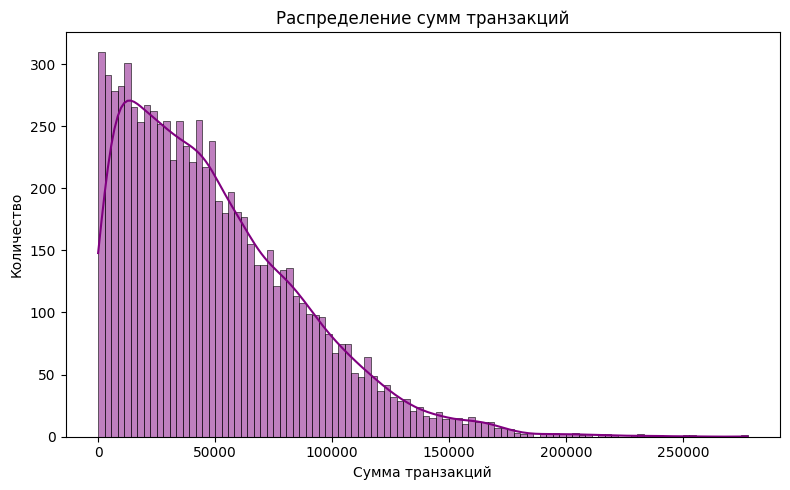

In [266]:
plt.figure(figsize= (8, 5))
sns.histplot(data = df_merged["amount"], bins = 100, kde=True, color = "purple", )
plt.ylabel("Количество")
plt.xlabel("Сумма транзакций")
plt.title("Распределение сумм транзакций")
plt.tight_layout()
plt.show()

##### Создать диаграмму выручки по услугам.

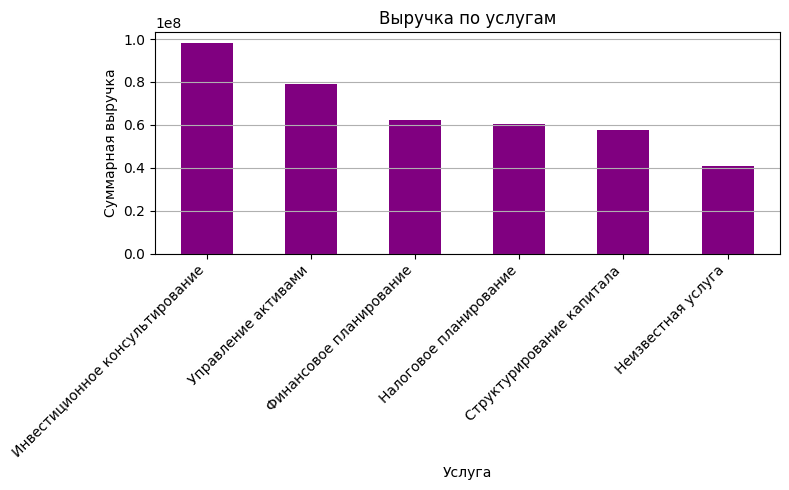

In [267]:
data_amount_service = df_merged.groupby('service')['amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
data_amount_service.plot(kind='bar', color='purple')
plt.title('Выручка по услугам')
plt.xlabel('Услуга')
plt.ylabel('Суммарная выручка')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### Построить график зависимости средней суммы транзакции от возраста клиентов.

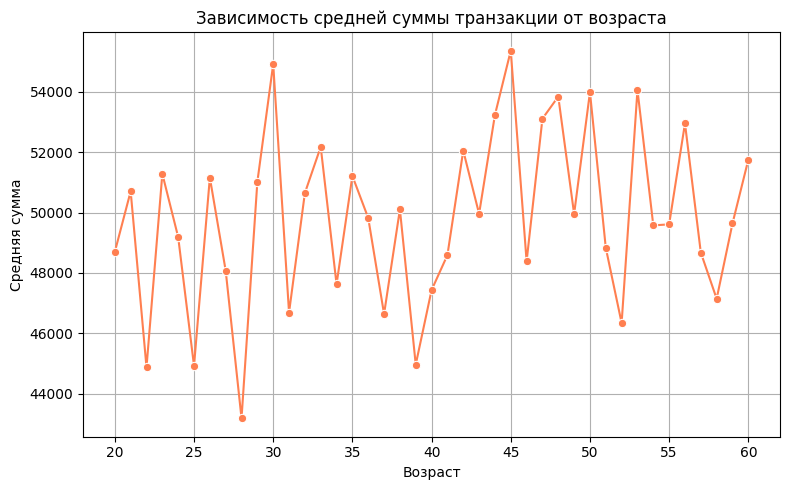

In [268]:
data_amount_age = df_merged.groupby("age")["amount"].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=data_amount_age.index, y=data_amount_age, marker='o', color='coral')
plt.title('Зависимость средней суммы транзакции от возраста')
plt.xlabel('Возраст')
plt.ylabel('Средняя сумма')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5. Прогнозирование.

##### Создание первой модели, анализ 

Импорт библиотек

In [269]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

Предобработка данных

In [270]:
df_merged['week'] = df_merged['transaction_date'].dt.to_period('W').apply(lambda r: r.start_time)
cols_to_drop = ["amount", "transaction_id", "client_id", "id", "transaction_date"]
X = df_merged.drop(columns=existing_cols)
Y = df_merged["amount"]

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

X= X.drop(columns=['week'])


In [271]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8012 entries, 0 to 8011
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   service         8012 non-null   category
 1   payment_method  8012 non-null   category
 2   city            8012 non-null   category
 3   consultant      8012 non-null   category
 4   age             7179 non-null   float64 
 5   gender          5313 non-null   category
 6   net_worth       7621 non-null   float64 
 7   asset_level     8012 non-null   category
dtypes: category(6), float64(2)
memory usage: 177.8 KB


Разделение данных на тестовую и тренировочную выборку

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 

In [273]:
model = XGBRegressor(enable_categorical=True, random_state = 42)

param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 0.9] 
}

GS = GridSearchCV(model, param_grid, cv = 5, scoring="neg_root_mean_squared_error", n_jobs=-1)

GS.fit(X_train, y_train)

modelXGB = GS.best_estimator_

In [274]:
y_pred = modelXGB.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
rmse = round(rmse)

print(f"RMSE: {rmse}")
print(f"Для сравнения посмотрим среднее значение у amount: {round(Y.mean())}")

predict_and_test = pd.DataFrame({
    "Predict": y_pred,
    "Actual": y_test
})

predict_and_test.head()

RMSE: 38431
Для сравнения посмотрим среднее значение у amount: 49745


,Predict,Actual
4523,60213.539062,8882.162414
4680,59847.257812,73022.469291
5832,43529.433594,9085.389845
3827,44899.050781,42864.095637
2470,44591.089844,49189.803068


Ошибка больша, и насколько я вижу по данным, значения колебляться рядом со средним, проверим теорию

In [275]:
y_mean = np.full_like(y_test, y_train.mean())

rmse_mean = root_mean_squared_error(y_test, y_mean)
rmse_mean = round(rmse_mean)

print(f"Ошибка чисто средних показаний: {rmse_mean}")

Ошибка чисто средних показаний: 38022


Как я и говорил, ошибка даже меньше нежели у XGB, проанализируем вклад различных признаков

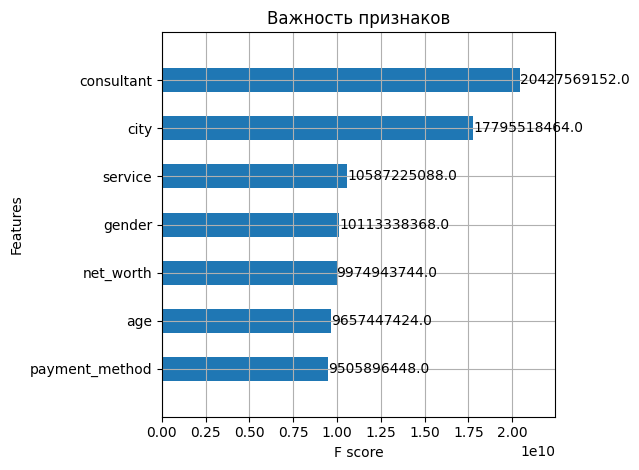

In [276]:
import xgboost as xgb

xgb.plot_importance(modelXGB, importance_type='gain', height=0.5)
plt.title("Важность признаков")
plt.tight_layout()
plt.show()

Думаю что модель переобучилась из-за множества городов и консультантов, под которых она подстроилась, удалим данные столбцы из данных тренировки,логарифмируем целевую переменную для сужения диапозона значений и добавим столбец отражающий временной ряд

In [277]:
print("Лучшие параметры:", GS.best_params_) # для справки

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}


##### Создание основной модели

In [278]:
def round_age(age):
    return 10 * (age // 10 % 10) + (5 if age % 10 >= 5 else 0)

In [300]:
df_merged['week_num'] = ((df_merged['week'] - df_merged['week'].min()) // 7).dt.days 
df_merged["age"] = df_merged["age"].apply(round_age)

cols_to_drop = ["amount", "transaction_id", "client_id", "id", "transaction_date", "week", "consultant", "city"]

X = df_merged.drop(columns=cols_to_drop)
Y = df_merged["amount"]

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

X.head()

,service,payment_method,age,gender,net_worth,asset_level,week_num
0,Структурирование капитала,Банковский перевод,40.0,Мужчина,2514729.46,Высокий капитал,0
1,Структурирование капитала,Неизвестно,25.0,Мужчина,566568.29,Средний капитал,10
2,Структурирование капитала,Неизвестно,55.0,Женщина,1896001.28,Высокий капитал,6
3,Структурирование капитала,Неизвестно,30.0,Мужчина,4865849.92,Высокий капитал,11
4,Инвестиционное консультирование,Кредитная карта,55.0,Женщина,3992281.84,Высокий капитал,7


In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [281]:
model = XGBRegressor(min_child_weight = 10, alpha = 0.1, enable_categorical=True, random_state = 42)

param_grid = {
    "n_estimators": [100, 350],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05],
    "subsample": [0.8, 0.9, 1] 
}

GS = GridSearchCV(model, param_grid, cv = 5, scoring="neg_root_mean_squared_error", n_jobs=-1)

GS.fit(X_train, y_train)

modelXGB = GS.best_estimator_

In [302]:
y_pred = modelXGB.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
rmse = round(rmse)

print(f"RMSE: {rmse}")
print(f"Для сравнения посмотрим среднее значение у amount: {round(Y.mean())}")

predict_and_test = pd.DataFrame({
    "Predict": y_pred,
    "Actual": y_test
})

predict_and_test.head()

RMSE: 38041
Для сравнения посмотрим среднее значение у amount: 49745


,Predict,Actual
4523,48238.894531,8882.162414
4680,49507.683594,73022.469291
5832,50581.441406,9085.389845
3827,50817.332031,42864.095637
2470,51174.929688,49189.803068


In [303]:
print("Лучшие параметры:", GS.best_params_)

Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


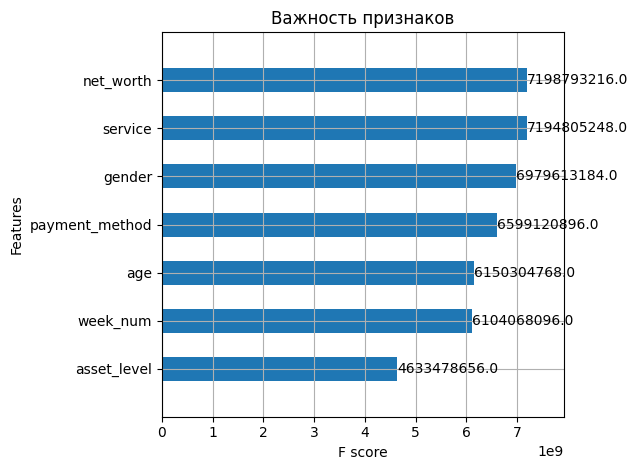

In [304]:
xgb.plot_importance(modelXGB, importance_type='gain', height=0.5)
plt.title("Важность признаков")
plt.tight_layout()
plt.show()

Осталась большая ошибка, попробуем линейную модель

In [285]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [288]:
df_merged.isnull().sum()

transaction_id         0
client_id              0
transaction_date       0
service                0
amount                 0
payment_method         0
city                   0
consultant             0
id                     0
age                  833
gender              2699
net_worth            391
asset_level            0
week                   0
week_num               0
dtype: int64

In [291]:
df_merged["age"].fillna(df_merged["age"].mean())
df_merged["net_worth"].fillna(df_merged["net_worth"].mean())
df_merged["gender"].fillna('Unknown')

df_merged.isnull().sum()

transaction_id      0
client_id           0
transaction_date    0
service             0
amount              0
payment_method      0
city                0
consultant          0
id                  0
age                 0
gender              0
net_worth           0
asset_level         0
week                0
week_num            0
dtype: int64

In [307]:
features = ['service', 'payment_method', 'age', 'gender', 'net_worth', 'asset_level', 'week_num']
target = 'amount'

X = df_merged[features]
y = df_merged[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['service', 'payment_method', 'gender', 'asset_level']
numerical_features = ['age', 'net_worth', 'week_num']

categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


RMSE: 38122.16
R2: -0.01


In [306]:
# Получим имена признаков после трансформации
feature_names_num = numerical_features
feature_names_cat = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Получим коэффициенты линейной модели
coefficients = model.named_steps['regressor'].coef_

# Объединим в DataFrame для анализа
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


                              Feature  Coefficient
14         asset_level_Низкий капитал -5088.412566
5   service_Структурирование капитала -2567.616058
15        asset_level_Средний капитал -2189.565518
12                     gender_Женщина  2053.836813
9         payment_method_Криптовалюта  2020.448761
3      service_Налоговое планирование -1959.664331
11          payment_method_Неизвестно  1519.927694
7     service_Финансовое планирование -1133.769642
4          service_Неизвестная услуга   954.633243
6         service_Управление активами  -775.723792
8      payment_method_Кредитная карта  -775.164636
1                           net_worth  -609.569352
2                            week_num  -549.467101
0                                 age   539.805452
13                     gender_Мужчина  -357.322725
10            payment_method_Наличные  -287.240762
